# Discrete Population Compartmental Model

Treats the population as discrete rather than continuous.

In [1]:
# Import those libraries
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from numpy import genfromtxt
import matplotlib.image as mpimg
import pandas as pd
import scipy
import time
from operator import add
from scipy.stats import binom
from numpy import random
from joblib import Parallel, delayed
import collections
import csv

In [2]:
## Import up sound alert dependencies
from IPython.display import Audio, display

def allDone():
    display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
## Insert whatever audio file you want above

In [3]:
waloc = pd.read_csv('/Users/Yuval/Desktop/Thesis/all-wa-pos.csv')#use this for all 297 towns
waloc = waloc.loc[waloc['Population'] >0]
# When doing big towns
waloc = waloc[:58]

# When ignoring sattelite towns
waloc = waloc.loc[(waloc['City / Town'] != 'Yanchep') & (waloc['City / Town'] != 'Bullsbrook') &
                  (waloc['City / Town'] != 'Mundijong') & (waloc['City / Town'] != 'Serpentine') &
                 (waloc['City / Town'] != 'Two Rocks') ]
waloc = waloc.reset_index()
waloc = waloc.drop(columns = ['index'])

# When also ignoring rural sattelite towns
waloc = waloc.loc[(waloc['City / Town'] != 'Pinjarra') & (waloc['City / Town'] != 'Drummond Cove') &
                  (waloc['City / Town'] != 'Bridgetown') & (waloc['City / Town'] != 'Binningup') &
                 (waloc['City / Town'] != 'Dampier') ]
waloc = waloc.reset_index()
waloc = waloc.drop(columns = ['index'])

In [4]:
# Create a network from a weekly dataset
my_data = genfromtxt('/Volumes/HardDrive/New_Workflow/symm_stoc_48/Town_Flow_20200322_20200328.csv',delimiter = ',')
A = nx.from_numpy_matrix(my_data)
A = nx.DiGraph(A)

# Use this network to label all the nodes, matching their index to the town name
towns = list(waloc['City / Town'])
labeldict = {}
for node in list(A.nodes()):
    labeldict[node] = towns[node]

In [5]:
# Read in all weekly adjacnecy matrices, assigning each entry to a dictionary.
st = os.listdir("/Volumes/HardDrive/New_Workflow/symm_stoc_48")

stoch = []
for i in st:
    if '._' not in i:
        stoch.append(i)
        
d = {}
for i in range(len(stoch)):
    d[str(i)] = pd.read_csv("/Volumes/HardDrive/New_Workflow/symm_stoc_48/"+stoch[i], header = None, sep =',')

In [6]:
# Create a df which is the average of all the flows, set it as key 100 in the dictionary 
# (so it's only referred to by choice)
df = d['0'].copy()
for i in range(1,len(stoch)):
    df += d[str(i)]
df = df/len(stoch)
d['100'] = df

In [87]:
d['lvl_1']=pd.read_csv("/Volumes/HardDrive/New_Workflow/restrictions/level_1.csv", header = None, sep =',')
d['lvl_2']=pd.read_csv("/Volumes/HardDrive/New_Workflow/restrictions/level_2.csv", header = None, sep =',')

In [88]:
def sveir(params,x,popn,changes,effic):
    xdot = list(np.zeros(7))
    eff1, eff2, eff3 = effic[0], effic[1], effic[2]
    xdot[0] = -params[0]*x[0]*x[5]/popn - changes[0] # Susceptible
    xdot[1] = -eff1*params[0]*x[1]*x[5]/popn +changes[0] - changes[1] #One Dose
    xdot[2] = -eff2*params[0]*x[2]*x[5]/popn + changes[1] - changes[2] # Two doses
    xdot[3] = -eff3*params[0]*x[3]*x[5]/popn + changes[2] + 1/84*x[6]
    xdot[4] = params[0]*x[0]*x[5]/popn + eff1*params[0]*x[1]*x[5]/popn + eff2*params[0]*x[2]*x[5]/popn + eff3*params[0]*x[3]*x[5]/popn - params[1]*x[4] #Exposed
    xdot[5] = params[1]*x[4] - params[2]*x[5] # Infected
    xdot[6] = params[2]*x[5] - 1/84*x[6] # Removed
    
    infected_daily = params[1]*x[4]
    
    return xdot, infected_daily

In [89]:
# This just double checks that the sveir equations actually sum to 0 for some random set of numbers

x = [i+1 for i in range(7)]
params = [7,11,12]
changes = [8,9,10]
popn = 30
eff1, eff2, eff3 = 0.6,0.4,0.8

sum([-params[0]*x[0]*x[5]/popn - changes[0], 
     -eff1*params[0]*x[1]*x[5]/popn +changes[0] - changes[1], 
     -eff2*params[0]*x[2]*x[5]/popn + changes[1] - changes[2], 
     -eff3*params[0]*x[3]*x[5]/popn + changes[2] + 1/84*x[6], 
     params[0]*x[0]*x[5]/popn + eff1*params[0]*x[1]*x[5]/popn, 
     eff2*params[0]*x[2]*x[5]/popn + eff3*params[0]*x[3]*x[5]/popn - params[1]*x[4],
     params[1]*x[4] - params[2]*x[5], params[2]*x[5] - 1/84*x[6]])

0.0

In [90]:
def bernoulli(flow_list,x,pop,total_out,num):
    
    #t = town
    
    p1 = x[0]/pop 
    p2 = x[1]/pop
    p3 = x[2]/pop
    p4 = x[3]/pop
    p5 = x[4]/pop
    p6 = x[5]/pop
    p7 = x[6]/pop
    
    #truth = True
    
#     vector = []
#     for i in range(flow):
#         r1 = random.rand()
#         if r1 <= p1:
#             vector.append(0)
#         elif (r1>p1) & (r1 <= (p1+p2)):
#             vector.append(1)
#         elif (r1 > p1+p2) & (r1 <= p1+p2+p3):
#             vector.append(2)
#         elif (r1 > p1+p2+p3) & (r1 <= p1+p2+p3+p4):
#             vector.append(3)
#         elif (r1 > p1+p2+p3+p4) & (r1 <= p1+p2+p3+p4+p5):
#             vector.append(4)
#         elif (r1 > p1+p2+p3+p4+p5) & (r1 <= p1+p2+p3+p4+p5+p6):
#             vector.append(5)
#         elif (r1 > p1+p2+p3+p4+p5+p6):
#             vector.append(6)
            
    vector = []
    #print(flow,p1,p2,p3,p4,p5,p6,p7)
    while len(vector) < total_out:
        r1 = random.rand()
        if (r1 <= p1) & (vector.count(0) < x[0]):
            vector.append(0)
        elif (r1>p1) & (r1 <= (p1+p2)) & (vector.count(1) < x[1]):
            vector.append(1)
        elif (r1 > p1+p2) & (r1 <= p1+p2+p3)& (vector.count(2) < x[2]):
            vector.append(2)
        elif (r1 > p1+p2+p3) & (r1 <= p1+p2+p3+p4) & (vector.count(3) < x[3]):
            vector.append(3)
        elif (r1 > p1+p2+p3+p4) & (r1 <= p1+p2+p3+p4+p5) & (vector.count(4) < x[4]):
            vector.append(4)
        elif (r1 > p1+p2+p3+p4+p5) & (r1 <= p1+p2+p3+p4+p5+p6) & (vector.count(5) < x[5]):
            vector.append(5)
        elif (r1 > p1+p2+p3+p4+p5+p6) & (vector.count(6) < x[6]):
            vector.append(6)
           
    
    random.shuffle(vector)
    
    flow_list = rounding(flow_list)
    cum_flow = [0]
    for f in flow_list:
        cum_flow.append(f+cum_flow[-1])
    
    mo = []
    for j in range(1,num+1):
        vec = vector[cum_flow[j-1]:cum_flow[j]]

        occ = dict(collections.Counter(vec))
        for i in range(7):
            occ[i] = occ.get(i,0)
        mo.append(occ)
        
#     for i in range(7):
#         if occ[i] > x[i]:
#             truth = False

#     p = [p1,p2,p3,p4,p5,p6,p7]
    #print(flow,p)
    
#     occ = []    
#     for i in range(7):
#         while True:
#             try:
#                 x_try = np.random.binomial(flow,p[i],1)[0]
#             except:
#                 print(p,x)
#             if x_try <= x[i]: # i.e. make sure it's not telling us to take more than the available amount
#                 occ.append(x_try)
#                 break
    return mo

In [91]:
mo = []

cum_flow = [0,1,5,5,5,10,15,16,16]
vector = [i for i in range(16)]

for j in range(1,9):
    vec = vector[cum_flow[j-1]:cum_flow[j]]
    print(vec)

[0]
[1, 2, 3, 4]
[]
[]
[5, 6, 7, 8, 9]
[10, 11, 12, 13, 14]
[15]
[]


In [92]:
llist = [1,2,3]
random.shuffle(llist)

In [93]:
llist

[1, 2, 3]

In [94]:
def dynamics(x_init, num, steps, params, popn, changes):
    
    x = x_init
    y = []
    changes = [0,0,0]
    
    town_infs = []
    for i in range(num):
        
        xy = []
        infected_daily = []
        for t in range(steps):
            if t == 0:
                xdot, infs = sveir(params, x[i],popn[i], changes, effic)
                xdot = [n/steps for n in xdot]
                xy.append([sum(n) for n in zip(*[x[i],xdot])])
                infected_daily.append(infs)
            else:
                xdot, infs = sveir(params, xy[-1],popn[i], changes, effic)
                xdot = [n/steps for n in xdot]
                xy.append([sum(n) for n in zip(*[xy[-1],xdot])])
                infected_daily.append(infs)
            #print(xy)
            
        town_infs.append(sum(infected_daily)/steps)
#         xxy = []
#         for j in xy[-1]:
#             try:
#                 xxy.append(int(j))
#             except:
#                 print(i,j)
#         y.append(xxy)
        #y.append([int(j) for j in xy[-1]])
        #print(i,j)
        y.append(rounding(xy[-1]))
        #y.append(xy[-1])
    
    return y, town_infs

In [95]:
def rounding(numbers):
    # This function does what I call 'collective rounding'
    # I.e. it considers what the other numbers are so that the overall sum is maintained
    # E.g. [1.2,1.2,1.4,1.2] gets rounded to [1,1,2,1] (which sums to 5 rather than 4, as the original list was)
    
    summ = round(sum(numbers))
    int_summ = sum([round(i) for i in numbers])
    
    if summ > int_summ:
        diff = summ - int_summ
        dec = [i - round(i) for i in numbers]
        for i in range(diff):
            ind = dec.index(max(dec))
            numbers[ind] += 1
            dec[ind] = 0
    elif summ < int_summ:
        diff = int_summ - summ
        dec = [i - round(i) for i in numbers]
        for i in range(diff):
            ind = dec.index(min(dec))
            numbers[ind] -= 1
            dec[ind] = 0
    
    return [round(j) for j in numbers]

In [96]:
rounding([1.2,1.2,1.4,1.2])

[1, 1, 2, 1]

In [97]:
rounding([0.8,0.8,0.6,0.8])

[1, 1, 0, 1]

In [98]:
rounding([0.1,0.8,0.8,0.8,0.8,0.9])

[0, 0, 1, 1, 1, 1]

In [99]:
def movement(x_init, day, num_towns,popn):
        
    #week = int(day//7)+70 # TAKE THIS 70 AWAY LATER (OR SET BASED ON DATES)
    
    #flow = round(d[str(week)].copy()*C/7)
    
    flow = round(d['lvl_2'].copy()*C/7)
    
    move = []
    for i in range(num_towns):
        temp_mo = []
        total_out = sum(list(flow[i]))
        pop = popn[i]
        mo = bernoulli(list(flow[i]),x_init[i],pop,total_out,num)
#        for j in range(num_towns):
            #print(i,j)
#             if int(flow[i][j]) == 0:
#                 mo = [0,0,0,0,0,0,0]
#             else:
# #                 truth = False
# #                 while truth == False:
#                 #print(x_init[i], pop)
#                 mo= bernoulli(int(flow[i][j]),x_init[i], pop)
            
        move.append(mo)
            
            #temp_mo.append(mo)
        
        #move.append(temp_mo)
        
    out = []   
    inc = []
    for i in range(num_towns):
        temp_out = []
        temp_inc = []
        for k in range(7):
            mini_out = []
            mini_inc = []
            for j in range(num_towns):
                mini_out.append(move[i][j][k])
                mini_inc.append(move[j][i][k])
            temp_out.append(sum(mini_out))
            temp_inc.append(sum(mini_inc))
        out.append(temp_out)
        inc.append(temp_inc)            

    return inc, out

In [100]:
## WA Data Processing
wa_data = pd.read_csv('/Users/Yuval/Desktop/Thesis/wa_health.csv')

# Daily cases
wa_totals = list(wa_data.iloc[0])[1:]
wa_totals = [i - 1134 for i in wa_totals]
wa_infs = [0]
for i in range(1,len(wa_totals)):
    wa_infs.append(wa_totals[i]-wa_totals[i-1])
    
    
# WA's population is 2491996 people over 5
# https://www.health.gov.au/sites/default/files/documents/2022/02/covid-19-vaccine-rollout-update-1-february-2022.pdf
# There are 377018 people between 5-15, so normalise the third dose based on that

first = list(wa_data.loc[wa_data['Source'] == 'COVID-live First Doses 5+'].iloc[0])[1:]
first_change = []
for f in range(len(first)-1):
    first_change.append(first[f+1] - first[f])

second = list(wa_data.loc[wa_data['Source'] == 'COVID-live Second Doses 5+'].iloc[0])[1:]
second_change = []
for f in range(len(second)-1):
    second_change.append(second[f+1] - second[f])

third = list(wa_data.loc[wa_data['Source'] == 'COVID-live Booster Doses 16+'].iloc[0])[1:]
third = [round(i*2491996/(2491996-377018)) for i in third]
third_change = []
for f in range(len(third)-1):
    third_change.append(third[f+1] - third[f])

uptakes = [first_change, second_change, third_change]


In [101]:
wa_data

,Source,21/12/2021,22/12/2021,23/12/2021,24/12/2021,25/12/2021,26/12/2021,27/12/2021,28/12/2021,29/12/2021,...,3/4/2022,4/4/2022,5/4/2022,6/4/2022,7/4/2022,8/4/2022,9/4/2022,10/4/2022,11/4/2022,12/4/2022
0,WA Health Dashboard Cum. Inf,1.134000e+03,1.138000e+03,1.141000e+03,1.143000e+03,1.144000e+03,1.147000e+03,1.150000e+03,1.158000e+03,1.165000e+03,...,2.160140e+05,2.245190e+05,2.319600e+05,2.385720e+05,2.444640e+05,2.500750e+05,2.551160e+05,2.605990e+05,2.666720e+05,2.717610e+05
1,COVID-live First Doses 5+,1.986875e+06,1.992161e+06,1.997187e+06,2.002212e+06,2.002212e+06,2.002212e+06,2.006864e+06,2.008828e+06,2.011031e+06,...,2.340766e+06,2.340646e+06,2.341266e+06,2.341433e+06,2.341632e+06,2.341916e+06,2.342179e+06,2.342242e+06,2.342105e+06,2.342516e+06
2,COVID-live First Doses 5+ (%),7.973000e-01,7.994000e-01,8.014000e-01,8.035000e-01,8.035000e-01,8.035000e-01,8.053000e-01,8.061000e-01,8.070000e-01,...,9.393000e-01,9.393000e-01,9.395000e-01,9.396000e-01,9.397000e-01,9.398000e-01,9.399000e-01,9.399000e-01,9.398000e-01,9.400000e-01
3,COVID-live Second Doses 5+,1.806957e+06,1.814130e+06,1.821007e+06,1.826920e+06,1.826920e+06,1.826920e+06,1.831330e+06,1.833249e+06,1.835446e+06,...,2.221809e+06,2.222788e+06,2.224949e+06,2.226691e+06,2.228403e+06,2.230563e+06,2.232709e+06,2.234253e+06,2.234954e+06,2.236690e+06
4,COVID-live Second Doses 5+ (%),7.251000e-01,7.280000e-01,7.307000e-01,7.331000e-01,7.331000e-01,7.331000e-01,7.349000e-01,7.357000e-01,7.365000e-01,...,8.916000e-01,8.920000e-01,8.928000e-01,8.935000e-01,8.942000e-01,8.951000e-01,8.960000e-01,8.966000e-01,8.969000e-01,8.975000e-01
5,COVID-live Booster Doses 16+,1.420580e+05,1.448990e+05,1.477400e+05,1.505810e+05,1.534220e+05,1.562630e+05,1.591040e+05,1.619450e+05,1.647860e+05,...,1.565505e+06,1.566635e+06,1.571367e+06,1.575500e+06,1.579327e+06,1.583267e+06,1.587059e+06,1.588866e+06,1.589962e+06,1.594112e+06
6,COVID-live Booster Doses 16+ (%),5.700000e-02,5.810000e-02,5.930000e-02,6.040000e-02,6.160000e-02,6.270000e-02,6.380000e-02,6.500000e-02,6.610000e-02,...,6.282000e-01,6.287000e-01,6.306000e-01,6.322000e-01,6.338000e-01,6.353000e-01,6.369000e-01,6.376000e-01,6.380000e-01,6.397000e-01


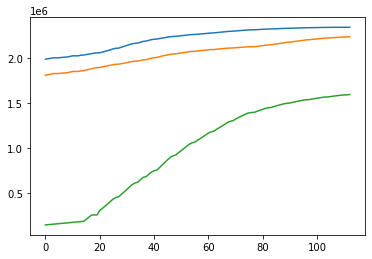

In [102]:
plt.plot(list(wa_data.iloc[1,1:]))
plt.plot(list(wa_data.iloc[3,1:]))
plt.plot(list(wa_data.iloc[5,1:]))

In [103]:
# Make it so there are no negatives (there were only two when I checked)
for i in range(len(uptakes)):
    for j in range(len(uptakes[i])):
        if uptakes[i][j] < 0:
            print(i,j)
            uptakes[i][j] = 0

0 103
0 110


In [104]:
# Find initial values

init_first_dose = list(wa_data.loc[wa_data['Source'] == 'COVID-live First Doses 5+ (%)'].iloc[0])[1]
init_second_dose = list(wa_data.loc[wa_data['Source'] == 'COVID-live Second Doses 5+ (%)'].iloc[0])[1]
init_third_dose = list(wa_data.loc[wa_data['Source'] == 'COVID-live Booster Doses 16+ (%)'].iloc[0])[1]

init1 = init_first_dose- init_second_dose-init_third_dose
init2 = init_second_dose - init_third_dose
init3 = init_third_dose

In [114]:
# Number of towns we'll be investigating in this run (max = 53 for bigs only, 58 with sattelite towns,
# 297 for all towns)

popn = list(waloc['Population'])

num = 48
one = 1/popn[0]
#x_init = [0.02,0.02,0.85,0.11-(5*infect),4*infect,infect,0]
x_init = [1-init1 - init2 - init3 - 5*one, init1 - 5*one, init2 - 5*one, init3 - 5*one, 16*one, 4*one,0]

# Go with 0 infections elsewhere
y_init = [1-init1 - init2 - init3, init1, init2, init3, 0, 0,0]
init = [x_init]
for i in range(num-1):
    init.append(y_init)

## Multiply it by population in each town.
town_init = []
for i in range(num):
    item = init[i]
    new_item = []
    for j in range(len(item)):
        new_item.append(round(item[j] * popn [i]))
    town_init.append(new_item)  
    
    
days = 180
steps = 10


#a1, a2,a3, L, D =4.26855088, 4.50297884, 6.        , 0.5       , 0.80237211
L = 2.5
a1, a2,a3, D = 0.97558821, 0.29647689, 0.54174642, 4.02110478
effic = [1-0.293, 1-0.128, 1-0.58]

C= 9*10**9

In [116]:
params = [a1, 1/L, 1/D]

cum_breaks = []
for it in range(1):
    start = time.time()
    model = [town_init]

    x_init = town_init

    day_infs = [0]

    for day in range(days):
        print(it, day)

        if day < 25:
            params[0] = a1
        elif (day>= 25) and (day <75):
            params[0] = a2
        elif day >=75:
            params[0] = a3
        
        if day < 112:
            changes = [uptakes[0][day],uptakes[1][day], uptakes[2][day]]
        else:
            changes = [0,0,0]

        dyn, town_infs = dynamics(model[-1], num, steps, params, popn, changes)

        day_infs.append(sum(town_infs) + day_infs[-1])

        inc, out = movement(dyn, day, num, popn)

        dynmov = []
        for i in range(num):
             dynmov.append([dyn[i][d] + inc[i][d] - out[i][d] for d in range(7)])

        model.append(dynmov)
    end = time.time()
    
    breaks = []
    for k in range(num):
        town_cases = []
        for day in range(days):
            town_cases.append(model[day][k][5])
        zeroes = np.nonzero(town_cases)[0]
        if len(zeroes) > 0:
            breaks.append(zeroes[0])
        else:
            breaks.append('NA')
    
    cum_breaks.append(breaks)
    
    print(end-start)
    

    
#     if day%7 == 0:
#         inc, out = movement(model[-1], day, num, popn)

#         dynmov = []
#         for i in range(num):
#              dynmov.append([dyn[i][d] + inc[i][d] - out[i][d] for d in range(7)])

#         model.append(dynmov)
#     else:
#         model.append(dyn)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
0 102
0 103
0 104
0 105
0 106
0 107
0 108
0 109
0 110
0 111
0 112
0 113
0 114
0 115
0 116
0 117
0 118
0 119
0 120
0 121
0 122
0 123
0 124
0 125
0 126
0 127
0 128
0 129
0 130
0 131
0 132
0 133
0 134
0 135
0 136
0 137
0 138
0 139
0 140
0 141
0 142
0 143
0 144
0 145
0 146
0 147
0 148
0 149
0 150
0 151
0 152
0 153
0 154
0 155
0 156
0 157
0 158
0 159
0 160
0 161
0 162
0 163
0 164
0 165
0 166
0 167
0 168
0 169
0 170
0 171
0 172
0 173
0 174
0 175
0 176
0 177
0 178
0 179
3156.9202523231506


In [117]:
with open("/Volumes/HardDrive/New_Workflow/breaks/lvl_2.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(cum_breaks)

In [ ]:
allDone()

Text(0.5, 0, 'Days from outbreak')

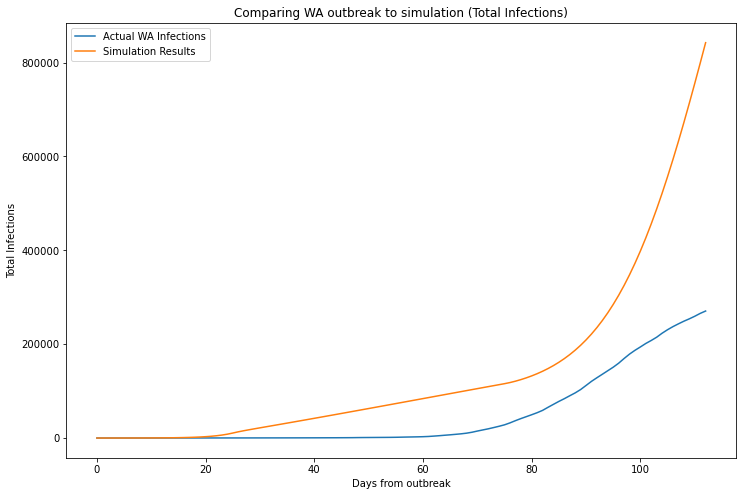

In [32]:
plt.figure(figsize = (12,8))
plt.title('Comparing WA outbreak to simulation (Total Infections)')
plt.plot(wa_totals, label = 'Actual WA Infections')
plt.plot(day_infs, label = 'Simulation Results')
plt.legend()
plt.ylabel('Total Infections')
plt.xlabel('Days from outbreak')

Text(0.5, 0, 'Days from outbreak')

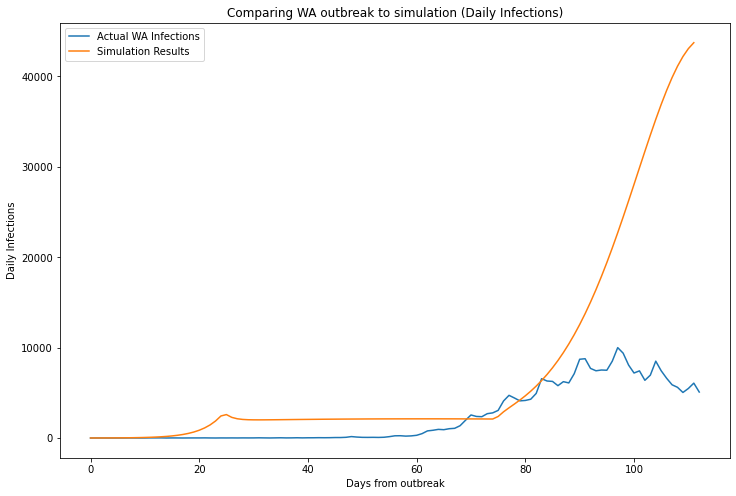

In [33]:
new_infs = [day_infs[i]-day_infs[i-1] for i in range(1,len(day_infs))]
plt.figure(figsize = (12,8))
plt.title('Comparing WA outbreak to simulation (Daily Infections)')
plt.plot(wa_infs, label = 'Actual WA Infections')
plt.plot(new_infs, label = 'Simulation Results')
plt.legend()
plt.ylabel('Daily Infections')
plt.xlabel('Days from outbreak')

In [63]:
breaks = []
for k in range(num):
    town_cases = []
    for day in range(days):
        town_cases.append(model[day][k][5])
    zeroes = np.nonzero(town_cases)[0]
    if len(zeroes) > 0:
        breaks.append(zeroes[0])
    else:
        breaks.append(0)
len(breaks)

48

In [64]:
breaks

[0,
 17,
 19,
 10,
 0,
 20,
 11,
 8,
 9,
 0,
 22,
 13,
 46,
 26,
 17,
 0,
 0,
 49,
 33,
 49,
 0,
 13,
 27,
 26,
 25,
 0,
 11,
 25,
 104,
 76,
 22,
 0,
 20,
 0,
 30,
 14,
 29,
 0,
 24,
 15,
 53,
 0,
 52,
 0,
 0,
 97,
 6,
 0]

In [65]:
# print when infection breaks in to each town
breaks = dict()
for i in range(num):
    for day in range(days):
        if model[day][i][5] > 0:
            breaks[towns[i]] = breaks.get(towns[i], day)

sd = {k: v for k, v in sorted(breaks.items(), key=lambda item: item[1])}
for item in sd:
    print(item, breaks[item])

print('-----Not Affected-----')
for i in range(num):
    if towns[i] not in breaks.keys():
        print(towns[i])

Perth 0
Mandurah 6
Broome 8
Port Hedland 9
Kalgoorlie-Boulder 10
Karratha 11
York 11
Northam 13
Tom Price 13
Wickham 14
Paraburdoo 15
Bunbury 17
Newman 17
Geraldton 19
Busselton 20
Kambalda West 20
Collie 22
Capel 22
Jurien Bay 24
Merredin 25
Donnybrook 25
Dunsborough 26
Harvey 26
Port Denison-Dongara 27
Cowaramup 29
Moora 30
Manjimup 33
Margaret River 46
Narrogin 49
Katanning 49
Kojonup 52
Wagin 53
Waroona 76
Augusta 97
Exmouth 104
-----Not Affected-----
Albany
Esperance
Carnarvon
Kununurra
Derby
Denmark
Mount Barker
Little Grove
Halls Creek
Kalbarri
Boddington-Ranford
Fitzroy Crossing
Wyndham


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


1874579.0
71090.0
31982.0
29875.0
29372.0
25329.0
15829.0
13985.0
13827.0
10420.0
7192.0
6549.0
6391.0
6039.0
4566.0
4425.0
4340.0
4274.0
4213.0
3701.0
3326.0
2956.0
2782.0
2750.0
2636.0
2558.0
2548.0
2520.0
2487.0
2397.0
2021.0
1906.0
1789.0
1703.0
1578.0
1572.0
1545.0
1545.0
1425.0
1359.0
1358.0
1349.0
1165.0
1146.0
1140.0
1109.0
80812.0
780.0


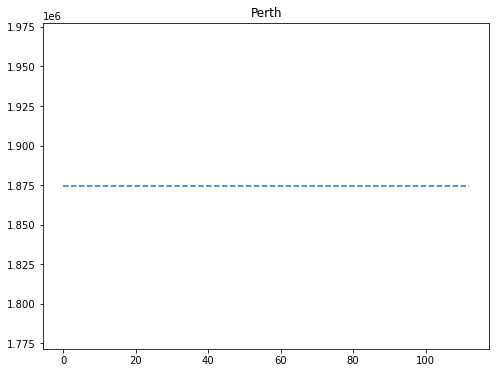

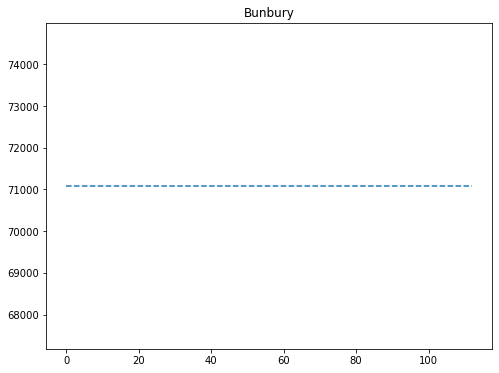

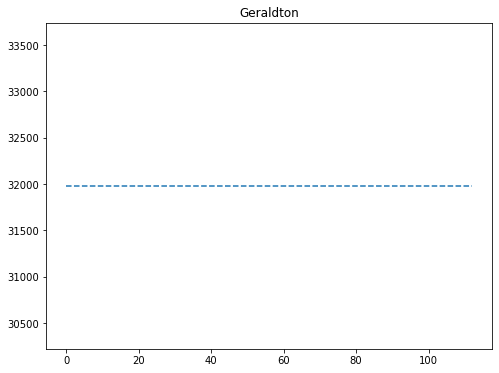

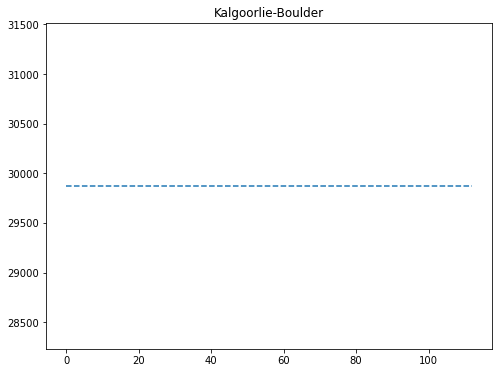

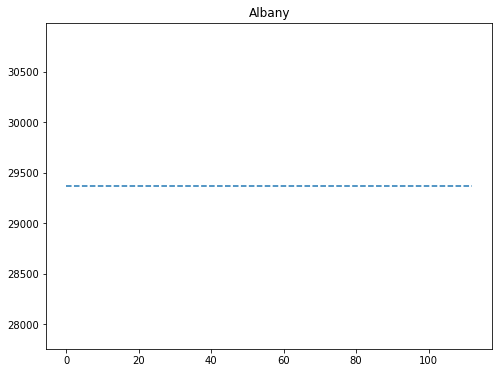

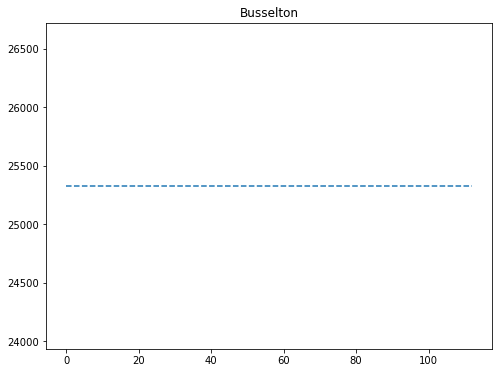

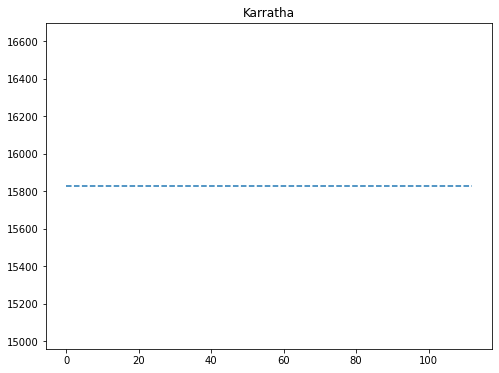

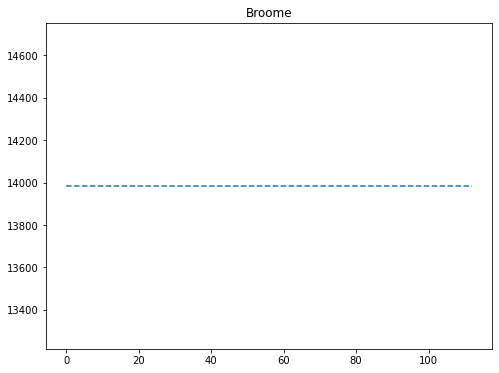

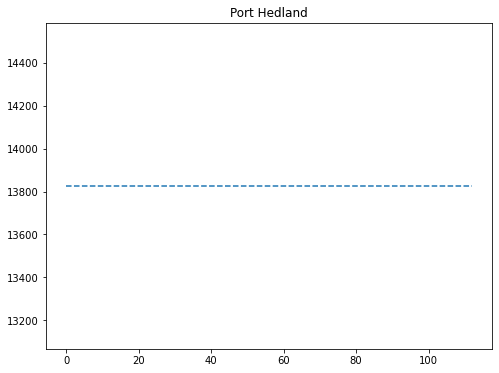

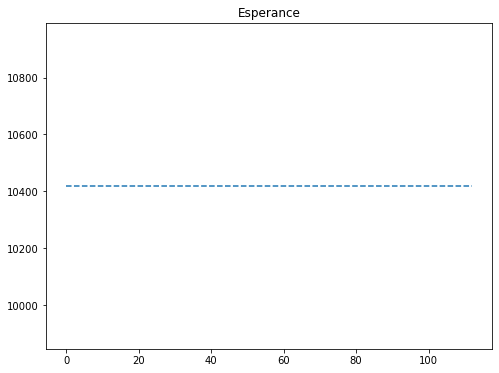

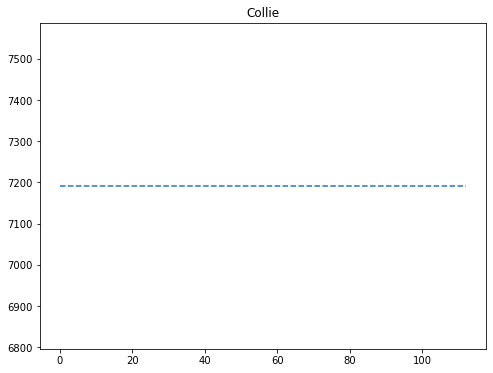

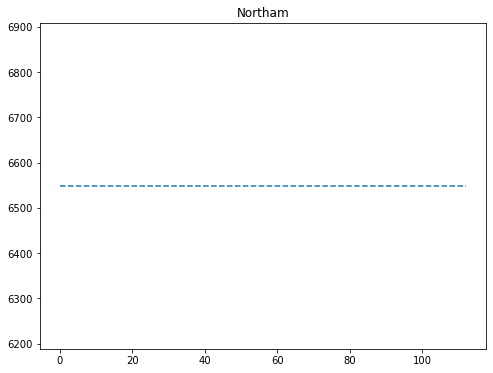

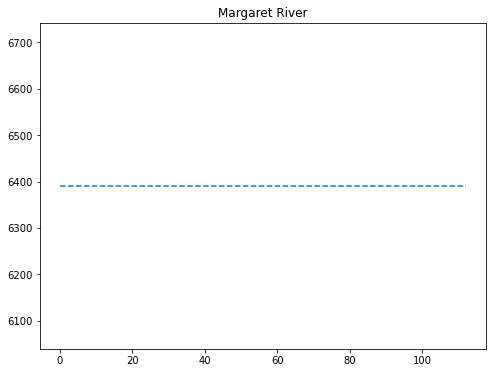

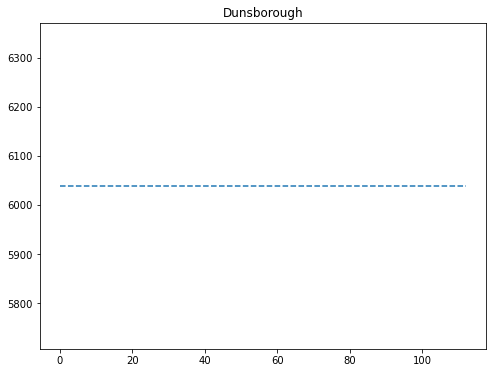

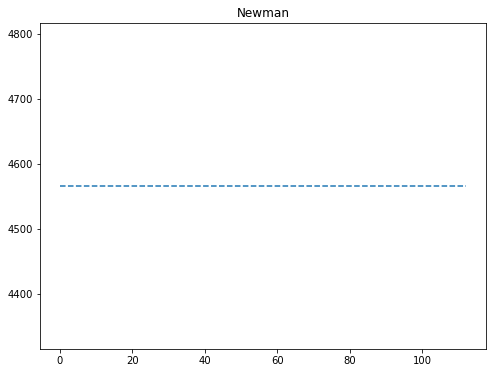

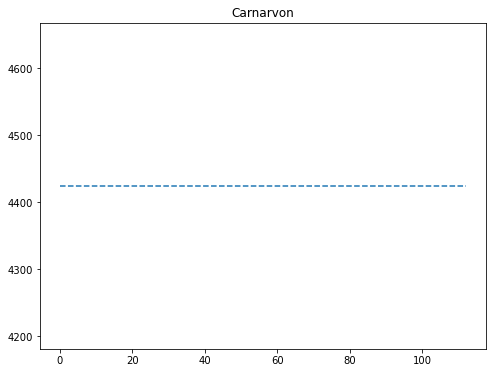

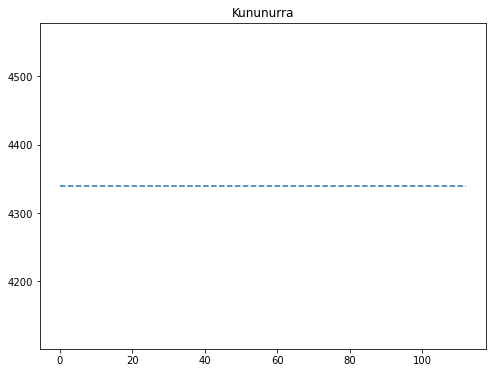

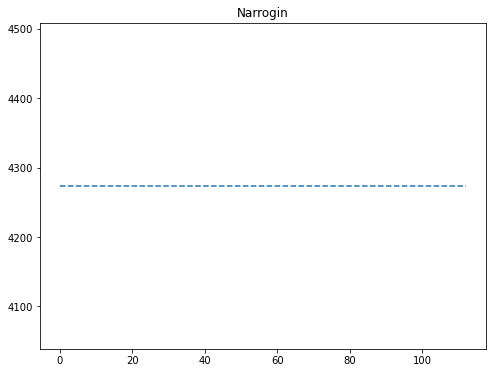

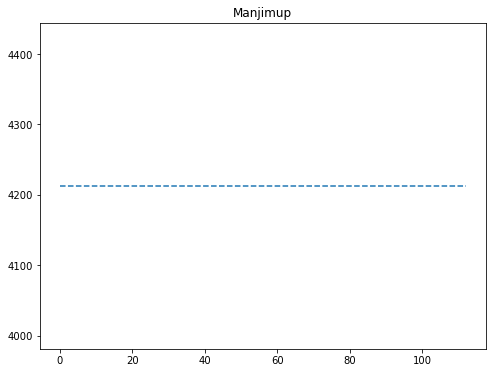

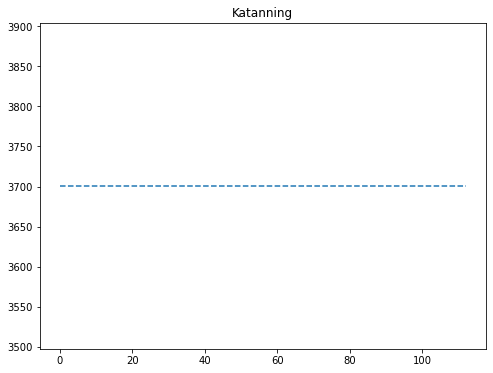

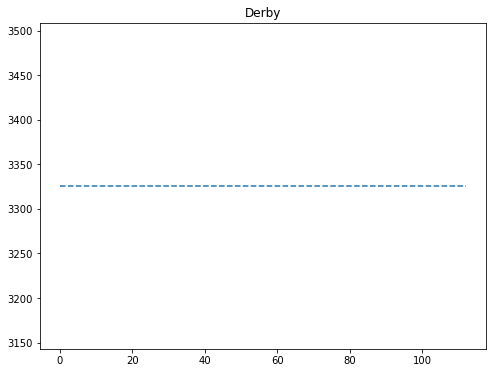

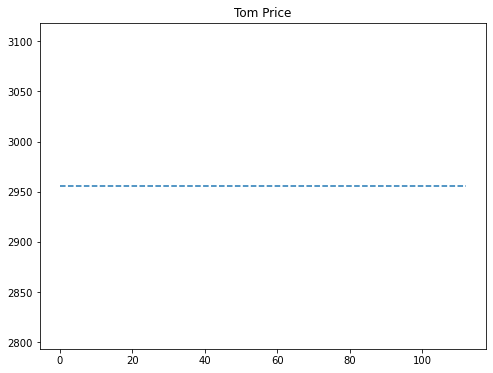

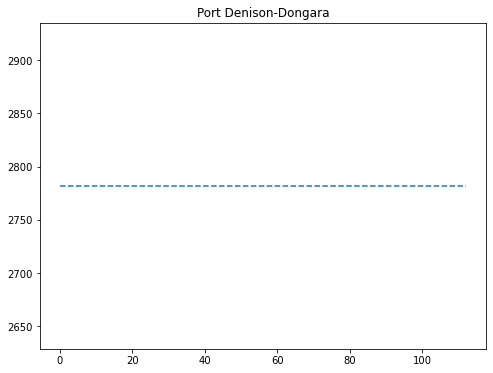

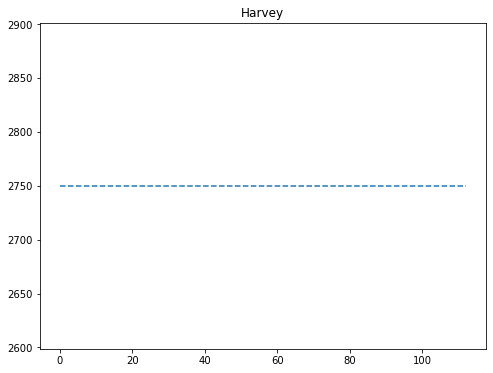

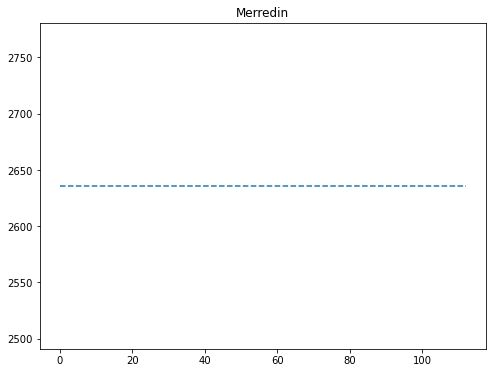

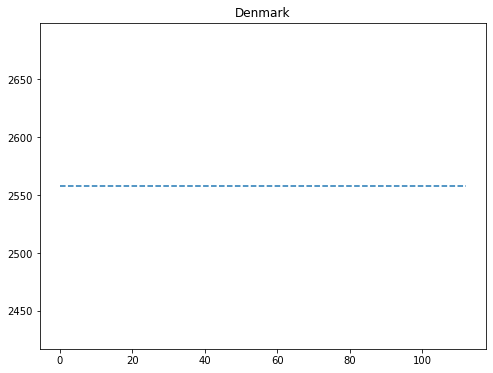

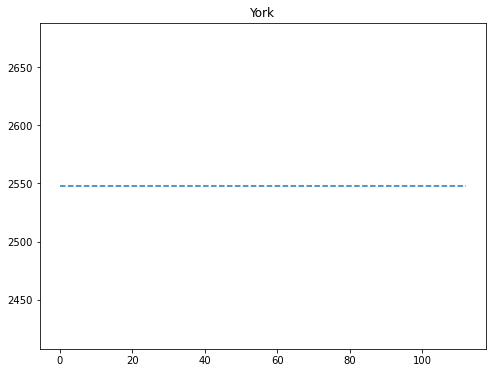

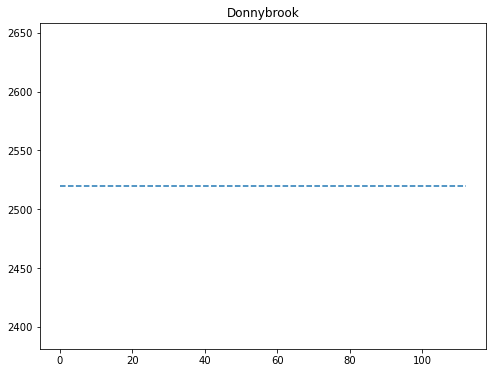

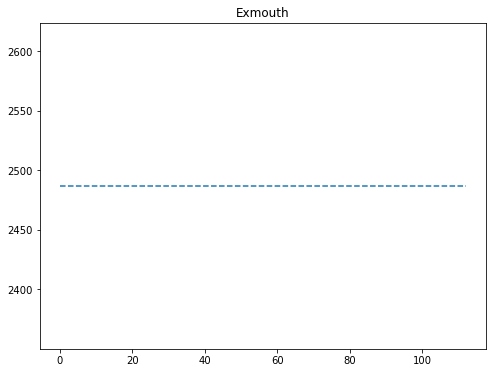

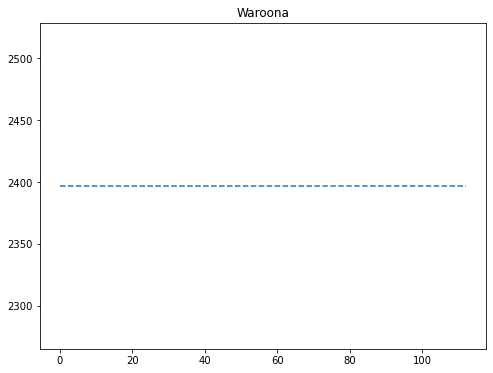

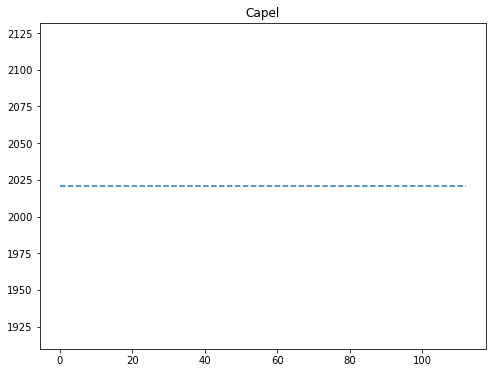

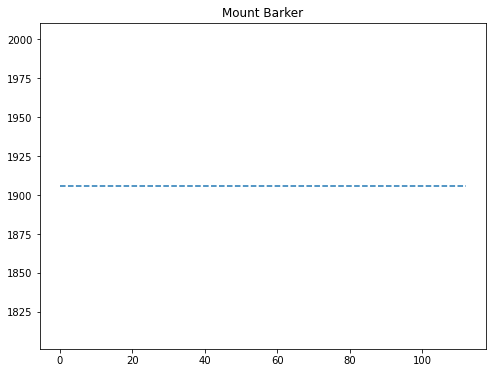

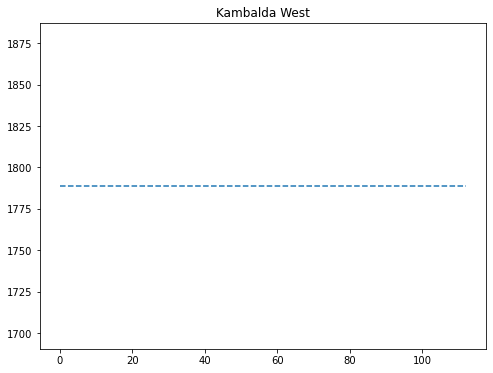

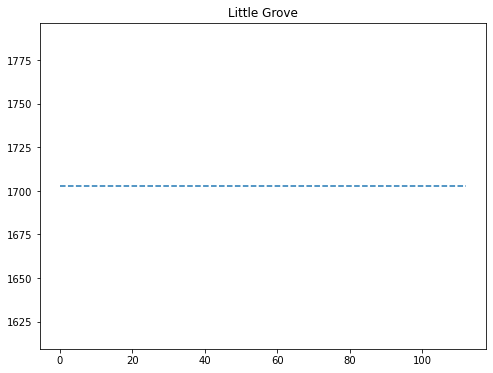

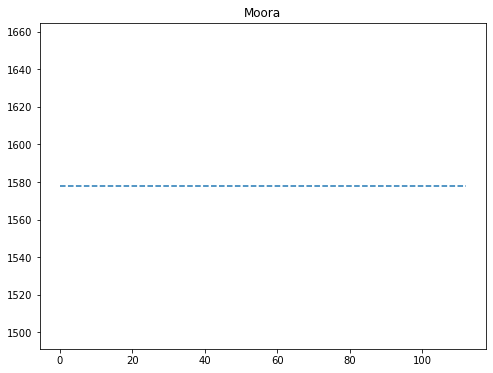

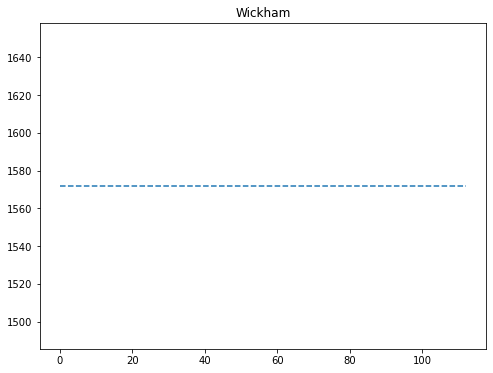

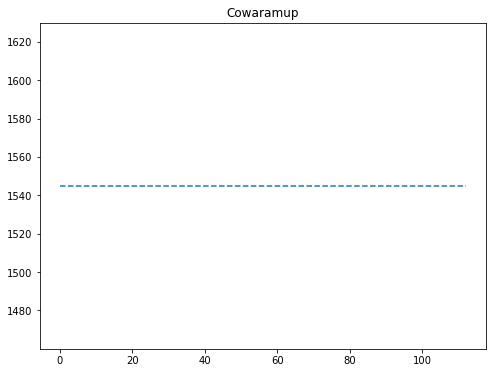

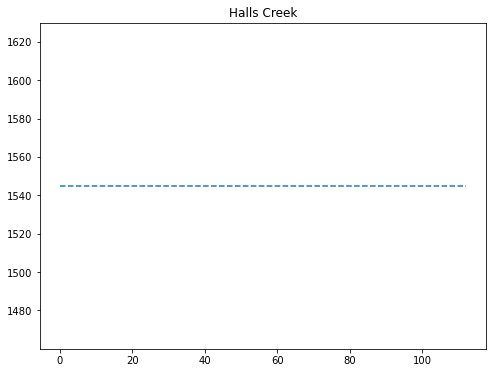

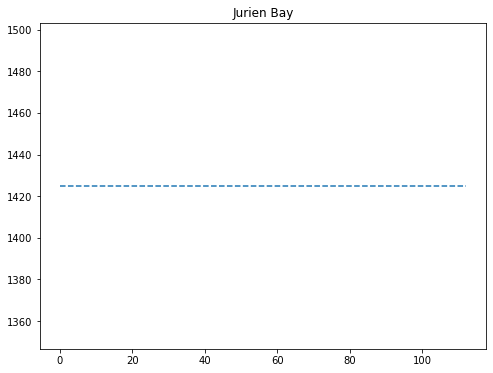

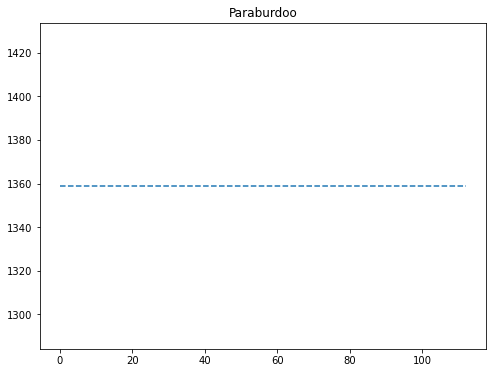

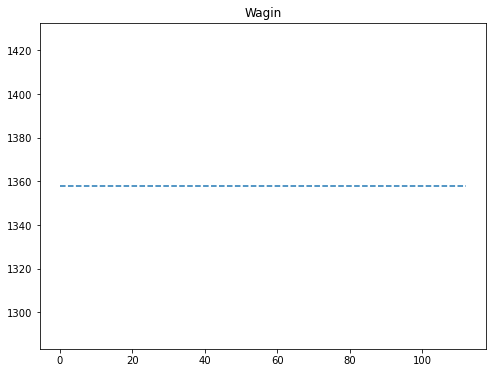

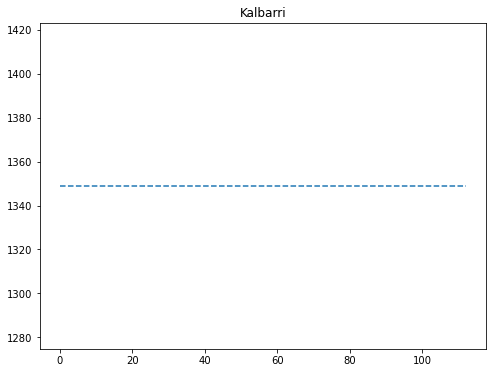

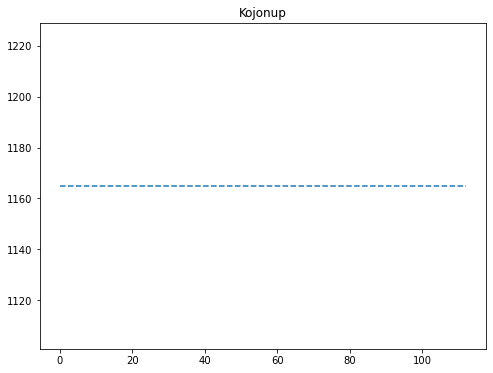

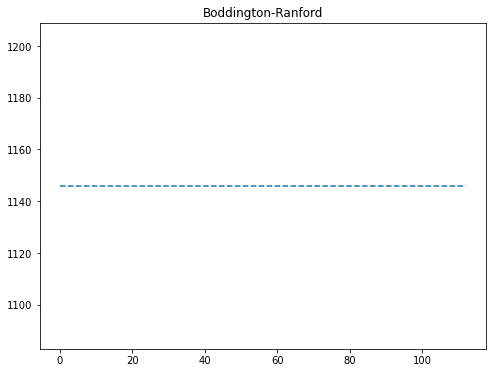

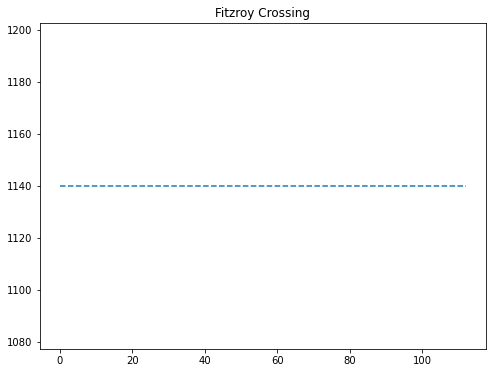

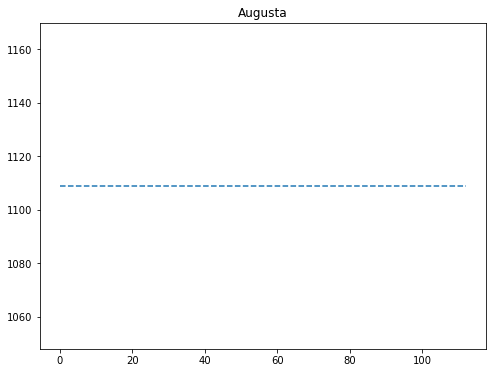

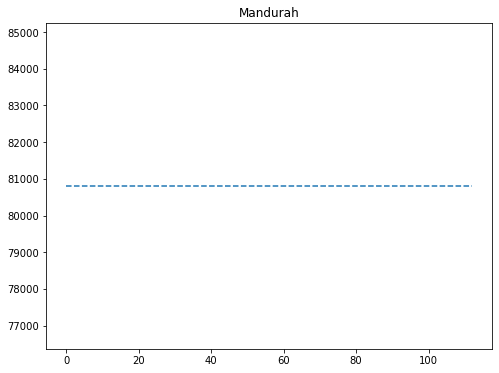

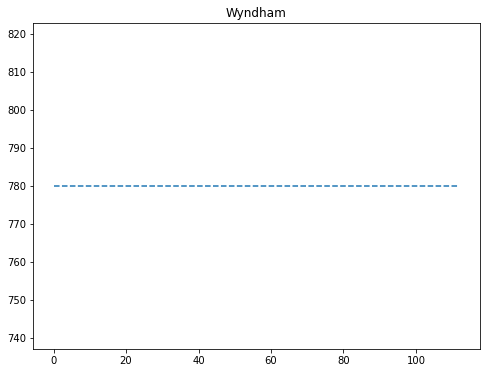

In [96]:
# compartments = ['Sus', 'V1', 'V2', 'V3', 'Exp', 'Inf', 'Rec']
tot = []
for town in range(num):
    plt.figure(figsize = (8,6))
    plt.title(towns[town])
    total_pop = []
    for k in range(8):
        if k < 7:
            continue
        #if k == 5:
#             llist = []
#             for day in range(len(model)):
#                 llist.append(model[day][town][k])
#             plt.plot(llist,label = compartments[k])
        else:
            for day in range(days):
                total_pop.append(sum(model[day][town]))
    tot.append(total_pop)
    plt.plot(total_pop, linestyle = 'dashed', label = 'Pop')
for t in tot:
    print(np.mean(t))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


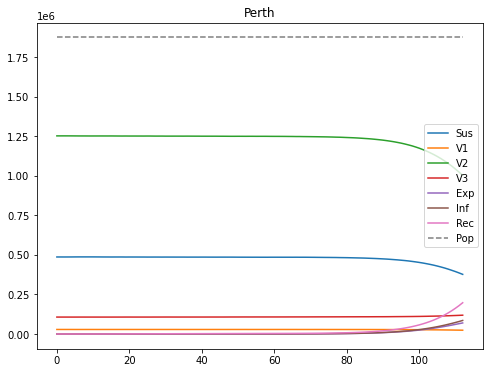

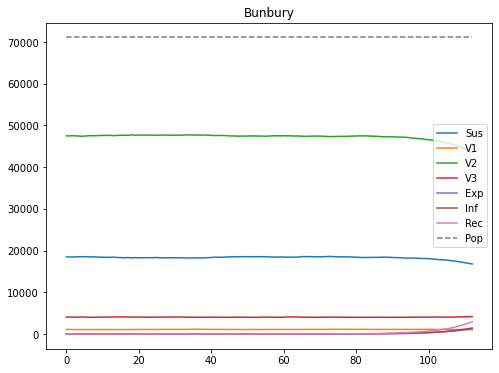

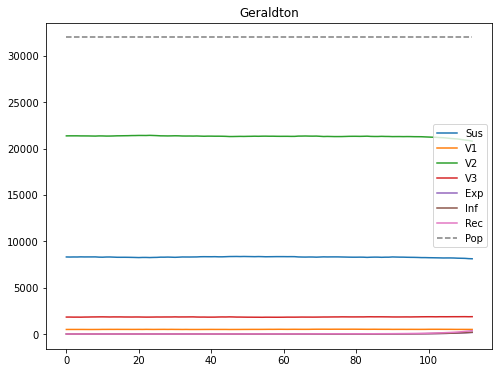

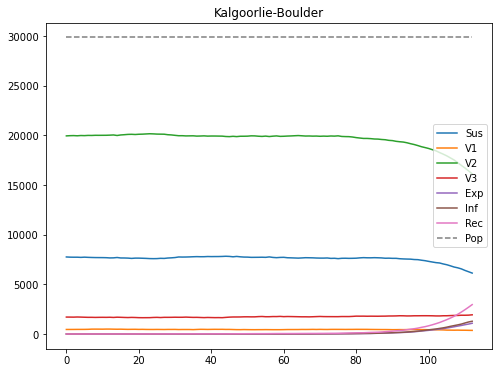

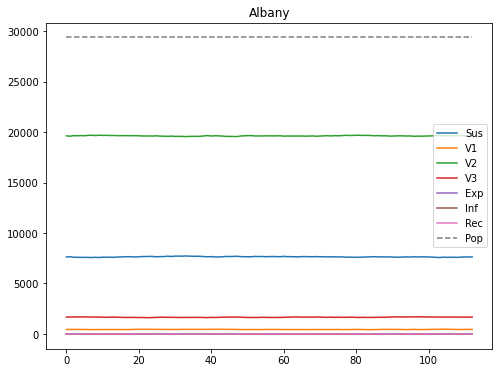

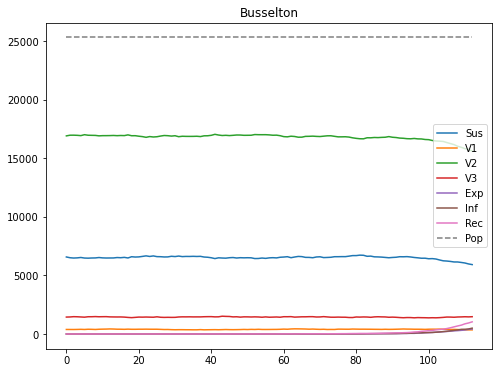

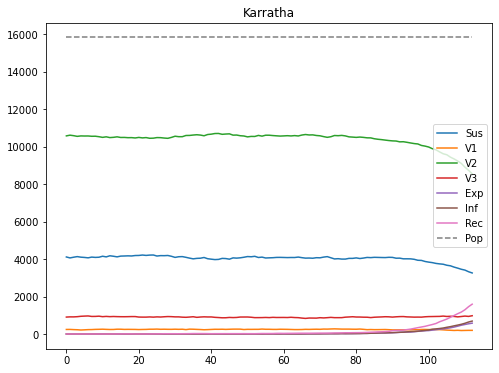

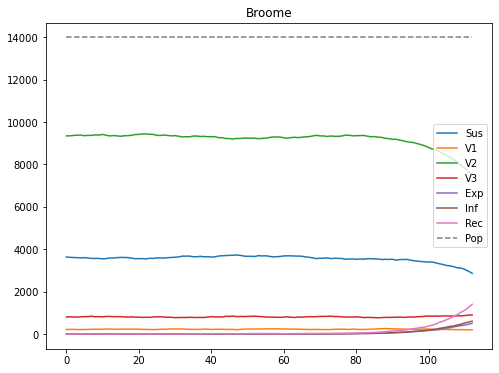

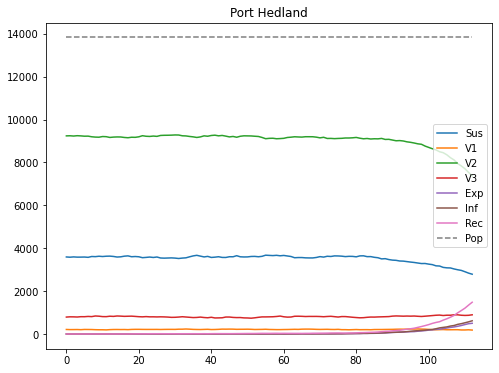

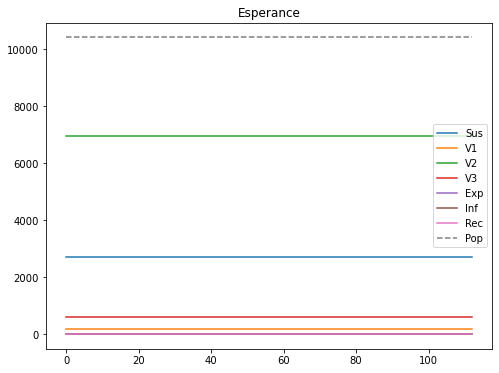

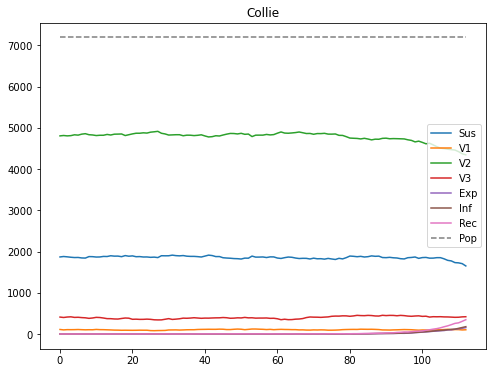

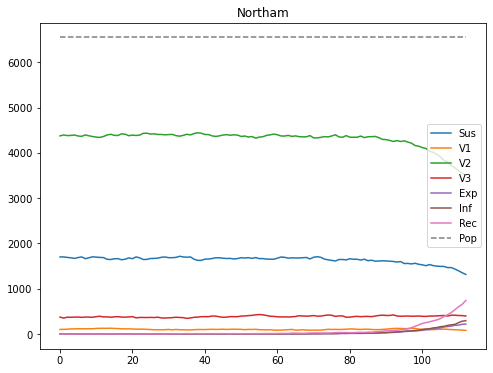

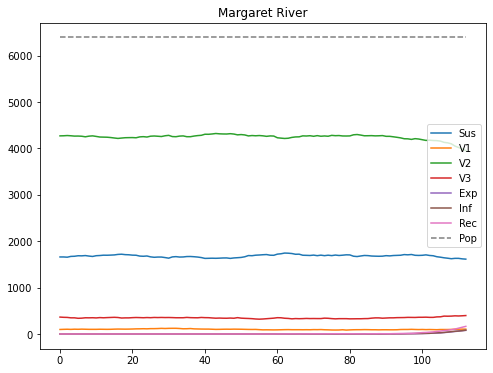

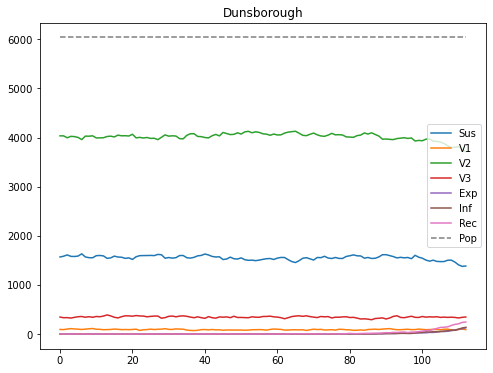

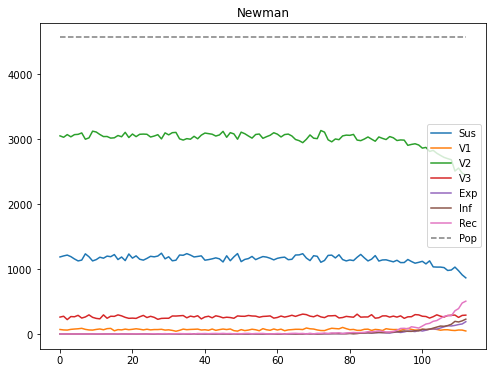

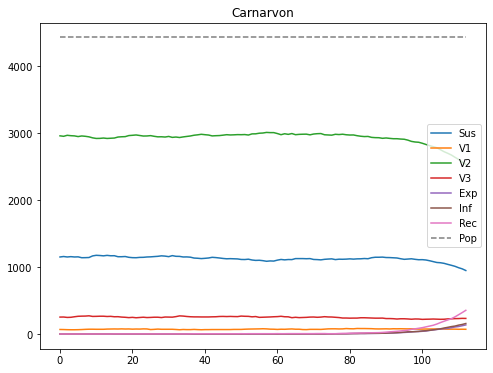

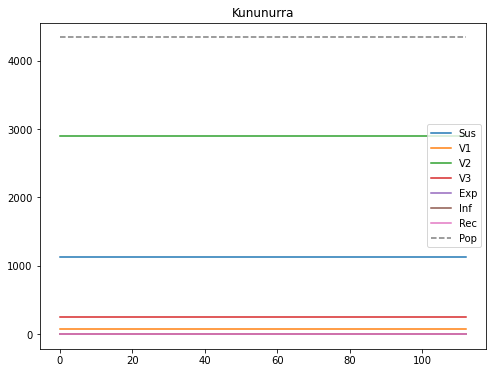

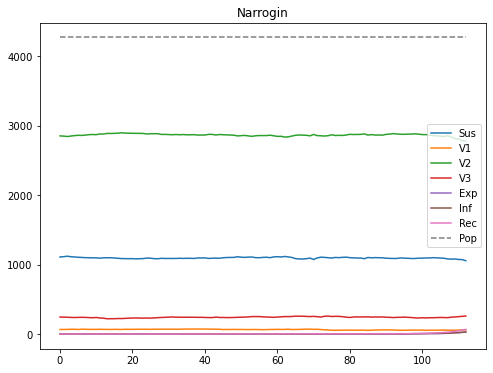

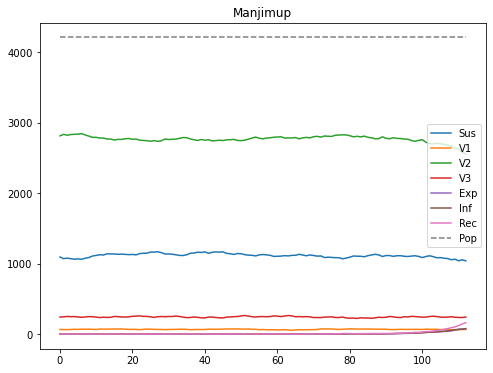

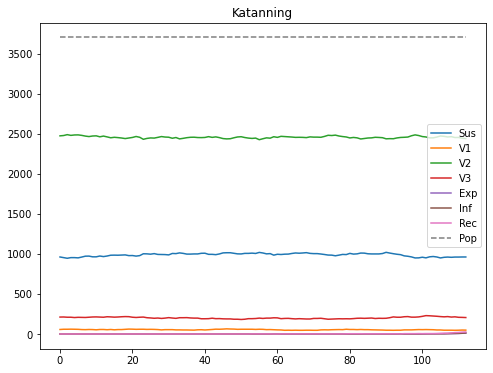

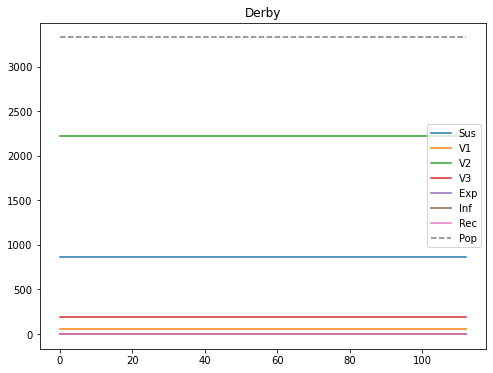

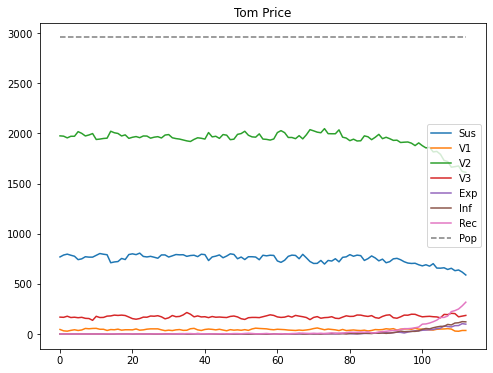

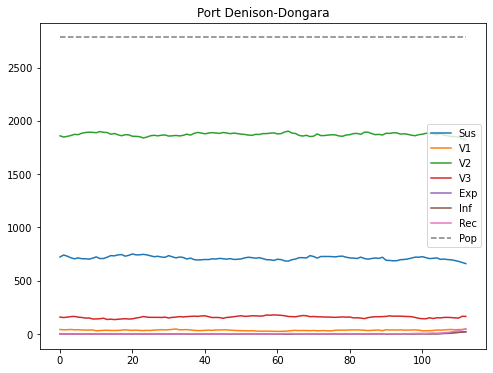

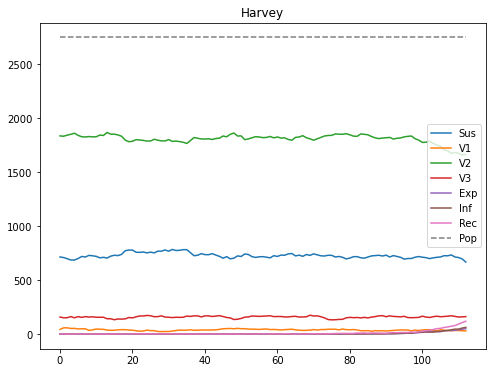

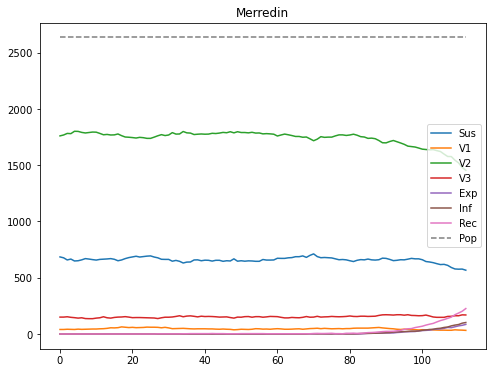

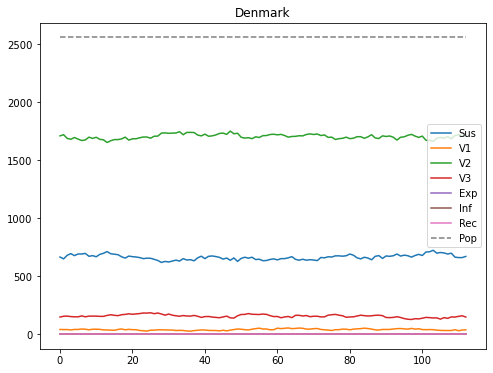

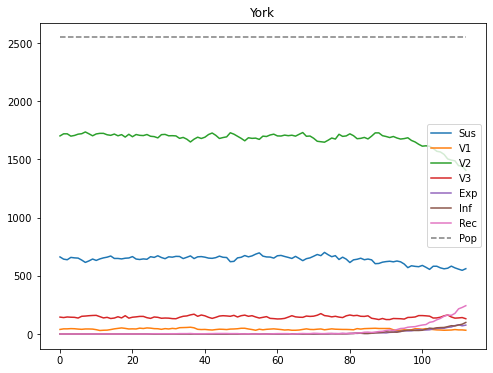

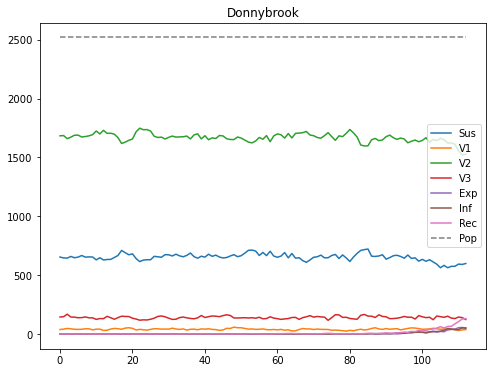

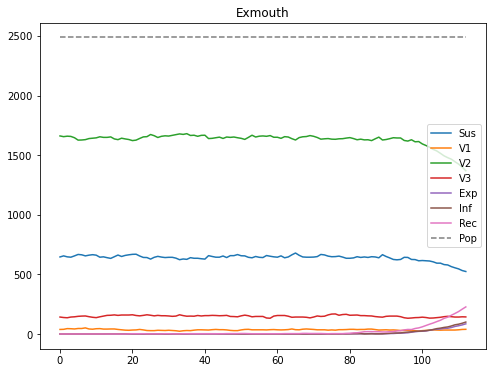

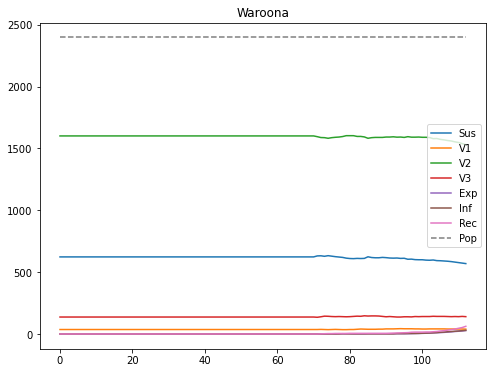

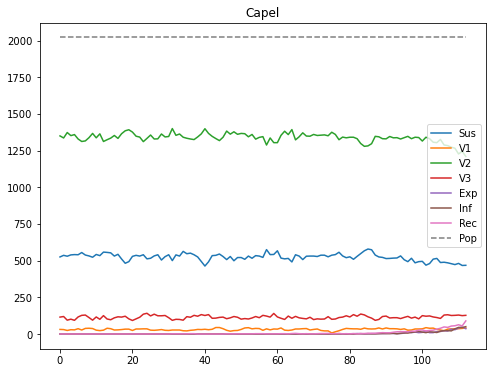

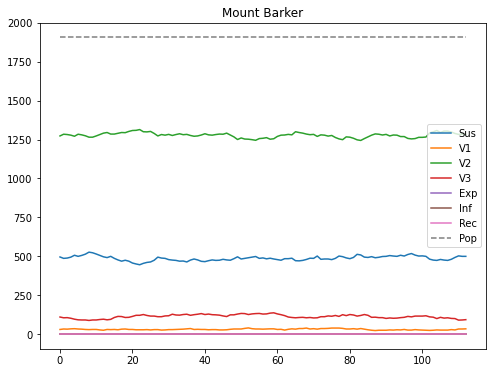

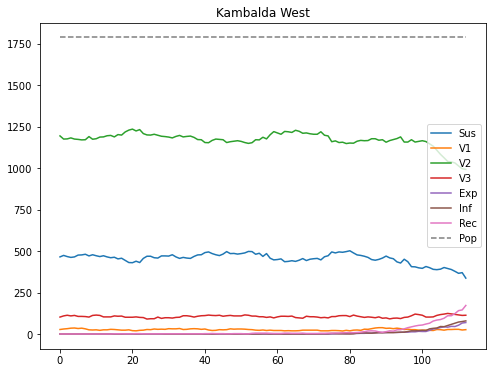

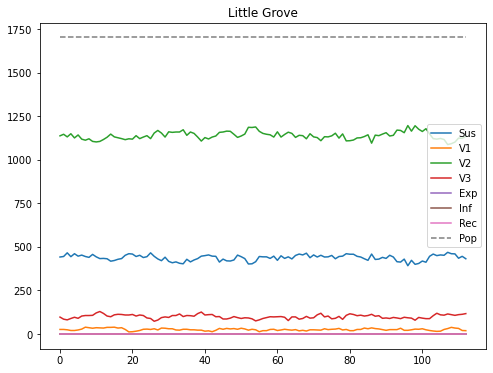

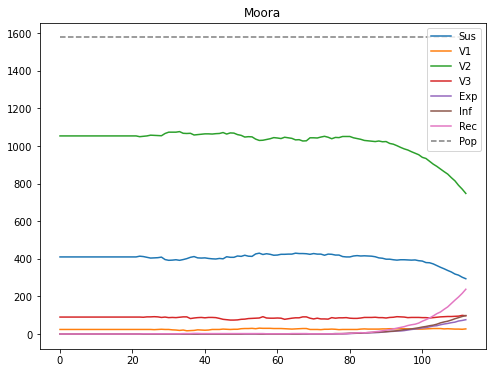

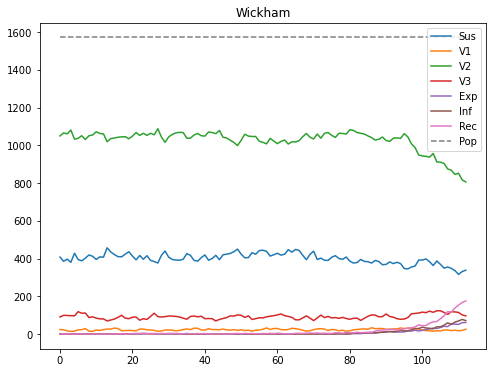

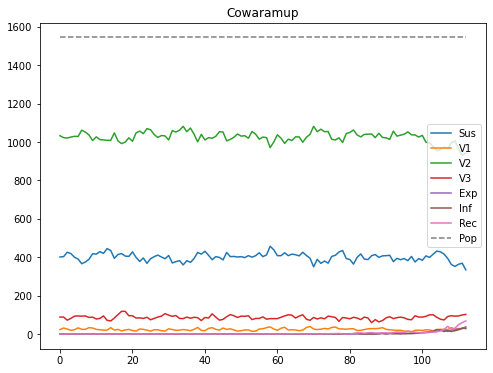

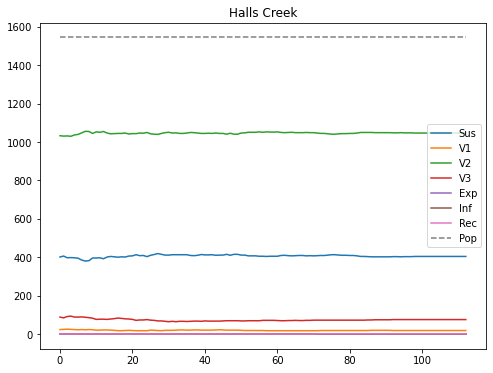

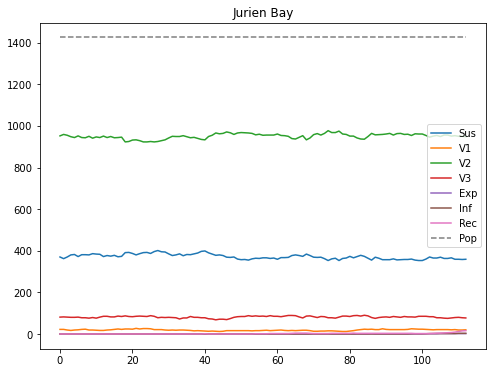

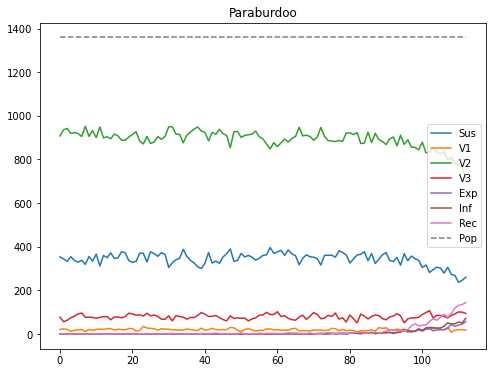

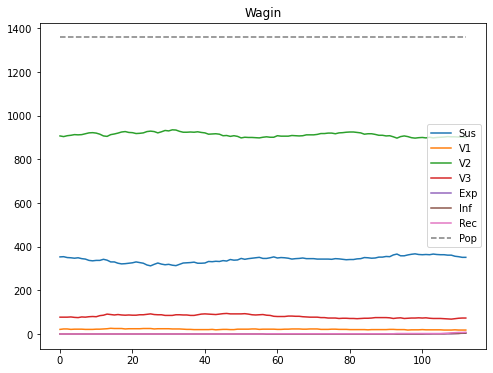

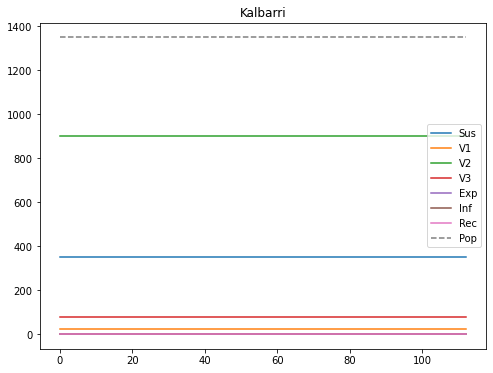

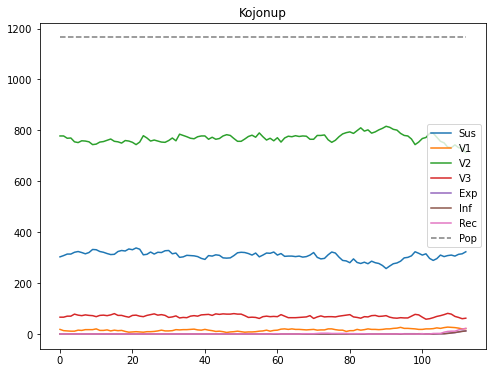

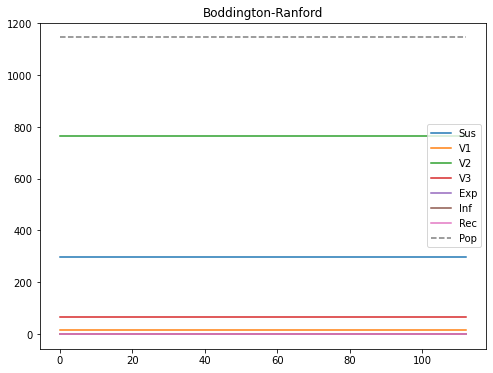

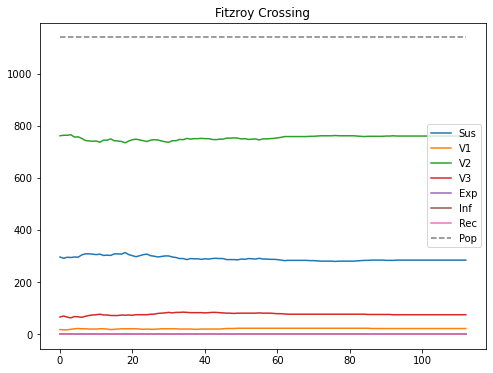

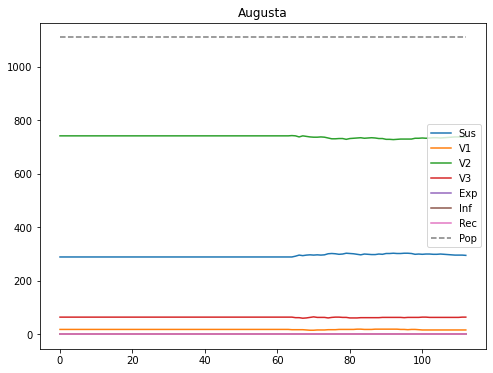

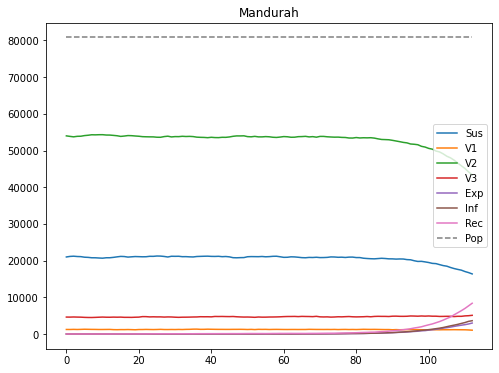

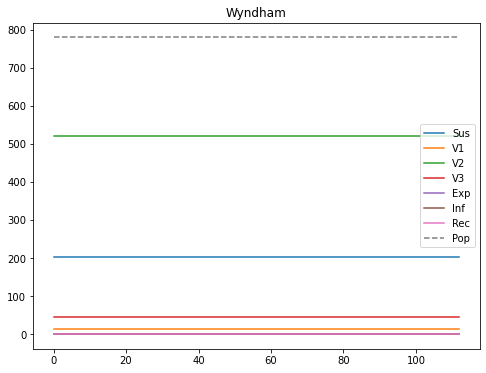

In [97]:
compartments = ['Sus', 'V1', 'V2', 'V3', 'Exp', 'Inf', 'Rec']
for town in range(num):
    plt.figure(figsize = (8,6))
    plt.title(towns[town])
    total_pop = []
    for k in range(8):
        if k < 7:
        #if k == 5:
            llist = []
            for day in range(len(model)):
                llist.append(model[day][town][k])
            plt.plot(llist,label = compartments[k])
        else:
            for day in range(days):
                total_pop.append(sum(model[day][town]))
    plt.plot(total_pop, linestyle = 'dashed', label = 'Pop')
    plt.legend()

In [91]:
#Check for negatives
for i in range(len(model)):
    for j in range(len(model[0])):
        for k in range(len(model[0][0])):
            if model[i][j][k] <0 :
                print(i,j,k,model[i][j][k])

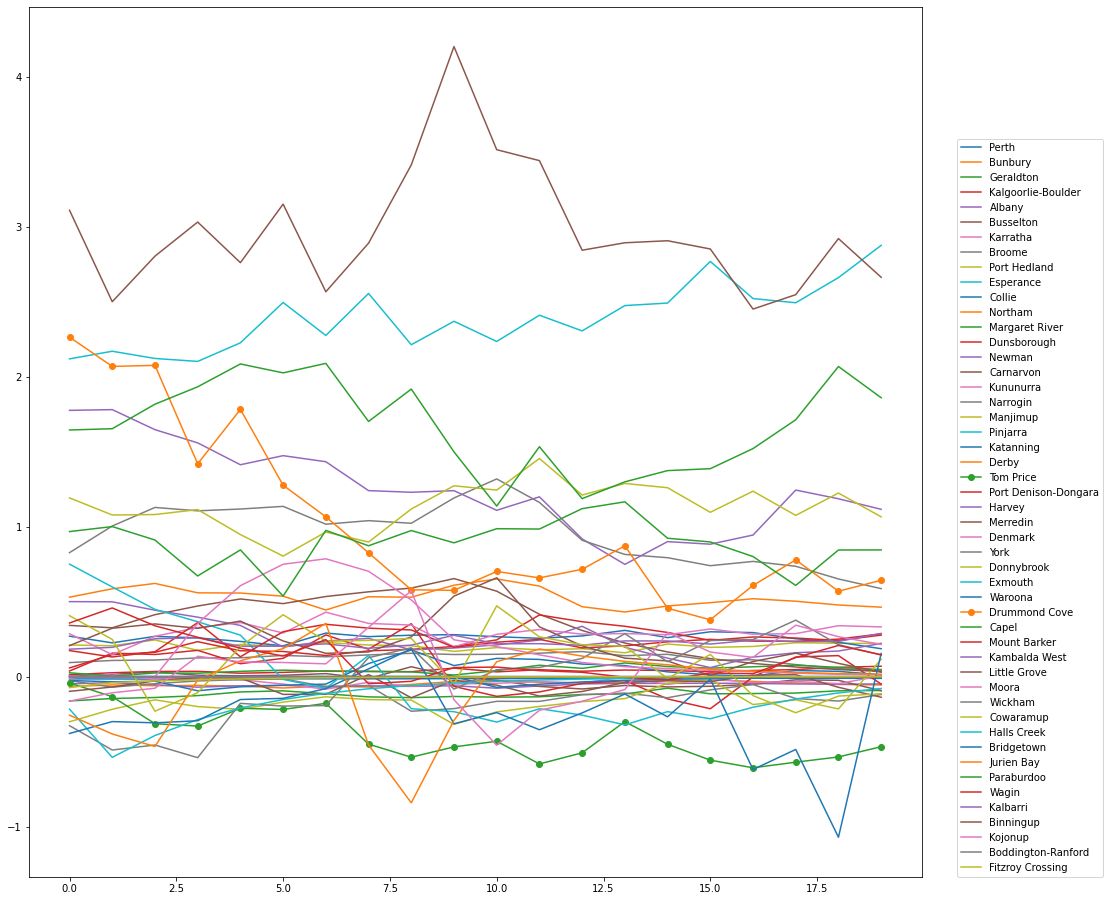

In [82]:
plt.figure(figsize = (16,16))
for i in range(num):
    di = []
    for j in range(20):
        df = d[str(70+j)].copy()*C
    #print(sum(df[50]))
    #print(sum(df.iloc[50]))
        di.append((sum(df[i]) - sum(df.iloc[i]))/popn[i])
    if i == 50 or i==31 or i == 22:
        plt.plot(di, label = towns[i], marker = 'o')
    else:
        plt.plot(di, label = towns[i])
plt.legend(loc=(1.04,0))
    #diff.append(di)
        #print('Diff = ', (sum(df[50]) - sum(df.iloc[50]))/popn[50], i)